# r/MSCS Dataset Analysis
This notebook performs various analyses on the cleaned `r_MSCS_posts_clean.jsonl` and `r_MSCS_comments_clean.jsonl` (or via the post_clean/comments_clean dataframes from the previous notebook).
In this notebook, we focus on:
1. **Sentiment Analysis over time**
2. **Linguistic Markers to identify international applicants**


In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import re
import json
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_colwidth', None)

# ── Locate notebook directory ────────────────────────────────────────────────
_SENTINEL = 'data/r_MSCS_posts_clean.jsonl'

def _locate_data_dir() -> Path:
    if (Path('.') / _SENTINEL).exists():
        return Path('.').resolve()
    _nb = os.environ.get('JPY_SESSION_NAME', '')
    if _nb:
        _p = Path(_nb).expanduser().resolve().parent
        if (_p / _SENTINEL).exists():
            return _p
    for _d in sys.path:
        if _d and (Path(_d) / _SENTINEL).exists():
            return Path(_d).resolve()
    raise FileNotFoundError(
        f"Cannot find '{_SENTINEL}'.\n"
        "Run clean_mscs_data.ipynb first, then open this notebook "
        "from its own directory (mscs/)."
    )

DATA_DIR = _locate_data_dir()
os.chdir(DATA_DIR)
print(f'Working directory: {DATA_DIR}')

# Load pre-cleaned data produced by clean_mscs_data.ipynb.
# Run that notebook first to generate the output files in data/.
posts    = pd.read_json('data/r_MSCS_posts_clean.jsonl',    lines=True)
comments = pd.read_json('data/r_MSCS_comments_clean.jsonl', lines=True)

# Reconstruct timezone-aware datetime from the unix timestamp column
# (created_dt was dropped before serialisation to avoid tz edge-cases).
posts['created_dt']    = pd.to_datetime(posts['created_utc'],    unit='s', utc=True)
comments['created_dt'] = pd.to_datetime(comments['created_utc'], unit='s', utc=True)

print(f'Posts    : {len(posts):,}')
print(f'Comments : {len(comments):,}')


Working directory: /media/ayush/F/Coding/598/mscs
Posts    : 18,372
Comments : 131,427


## 1. Sentiment Analysis Over Time
We will use NLTK's VADER SentimentIntensityAnalyzer to calculate the sentiment of posts and comments over time.

/tmp/ipykernel_264948/1141642752.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['month'] = posts['created_dt'].dt.to_period('M')


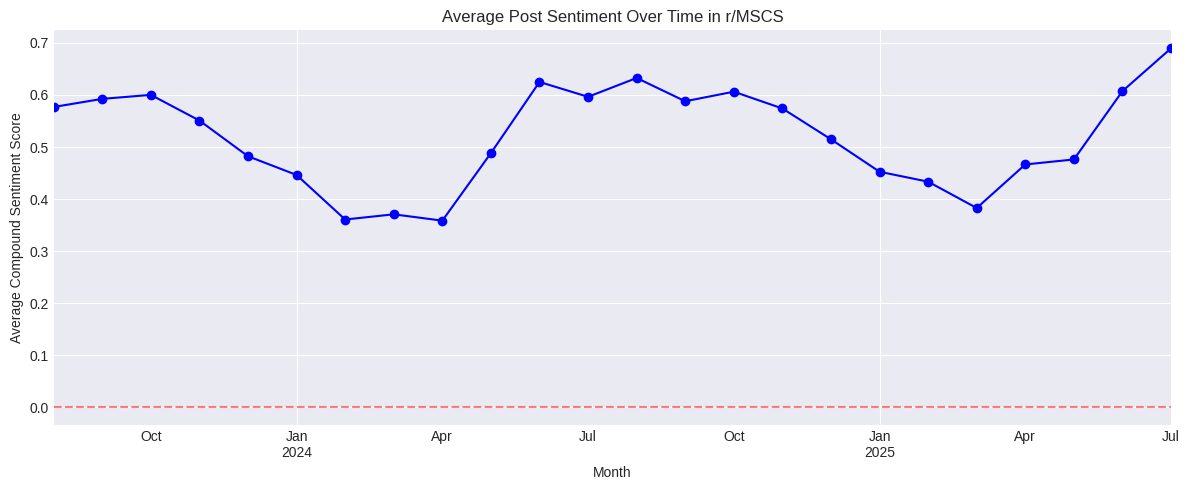

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

sid = SentimentIntensityAnalyzer()

# Calculate sentiment for posts
# Use title + selftext
posts['full_text'] = posts['title'].fillna('') + ". " + posts['selftext'].fillna('')
posts['sentiment_score'] = posts['full_text'].apply(lambda text: sid.polarity_scores(text)['compound'])

# Group by month
posts['month'] = posts['created_dt'].dt.to_period('M')
monthly_sentiment = posts.groupby('month')['sentiment_score'].mean()

plt.figure(figsize=(12, 5))
monthly_sentiment.plot(color='blue', marker='o')
plt.title('Average Post Sentiment Over Time in r/MSCS')
plt.xlabel('Month')
plt.ylabel('Average Compound Sentiment Score')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('outputs/sentiment_over_time.png', dpi=150)
plt.show()

## 2. International vs Domestic Applicant Signals

`r/MSCS` skews heavily international — particularly Indian applicants pursuing an MS in CS.
We classify posts with two independent marker sets and compare behaviour,
using the same scheme as `r/gradadmissions` for a direct cross-subreddit comparison.

**International markers** (language borrowed from non-US education systems):
* `CGPA` or `X/10` GPA notation
* `B.Tech` / `B.E.` degree names (India, some South/SE-Asian universities)
* `Lakhs` / `Crores` / `INR` — Indian currency
* `IELTS` / `TOEFL` — English proficiency tests required only for non-native English speakers
* `Tier 1/2/3` — Indian college ranking vernacular

**Domestic (US) markers**:
* GPA `X/4` or `out of 4` notation — US 4-point scale
* `FAFSA` — US federal student-aid form, unknown outside the US
* `in-state` / `out-of-state` — tuition distinction meaningful only in the US
* `state school` / `SAT score` / `ACT score`


Total posts       : 18,372
  Intl only       : 4,259  (23.2%)
  Domestic only   : 296  (1.6%)
  Both signals    : 370  (2.0%)
  Unclassified    : 13,447  (73.2%)

Mean VADER sentiment:
  Intl-only    : 0.674
  Domestic-only: 0.692
  Unclassified : 0.399

Admit / Reject mention rates:
  Intl-only         admit 20.6%  reject 4.9%  ratio 4.24:1
  Domestic-only     admit 27.0%  reject 6.4%  ratio 4.21:1
  Unclassified      admit 24.7%  reject 6.2%  ratio 4.01:1


/tmp/ipykernel_264948/3598764213.py:104: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['_marker_month'] = posts['created_dt'].dt.to_period('M')


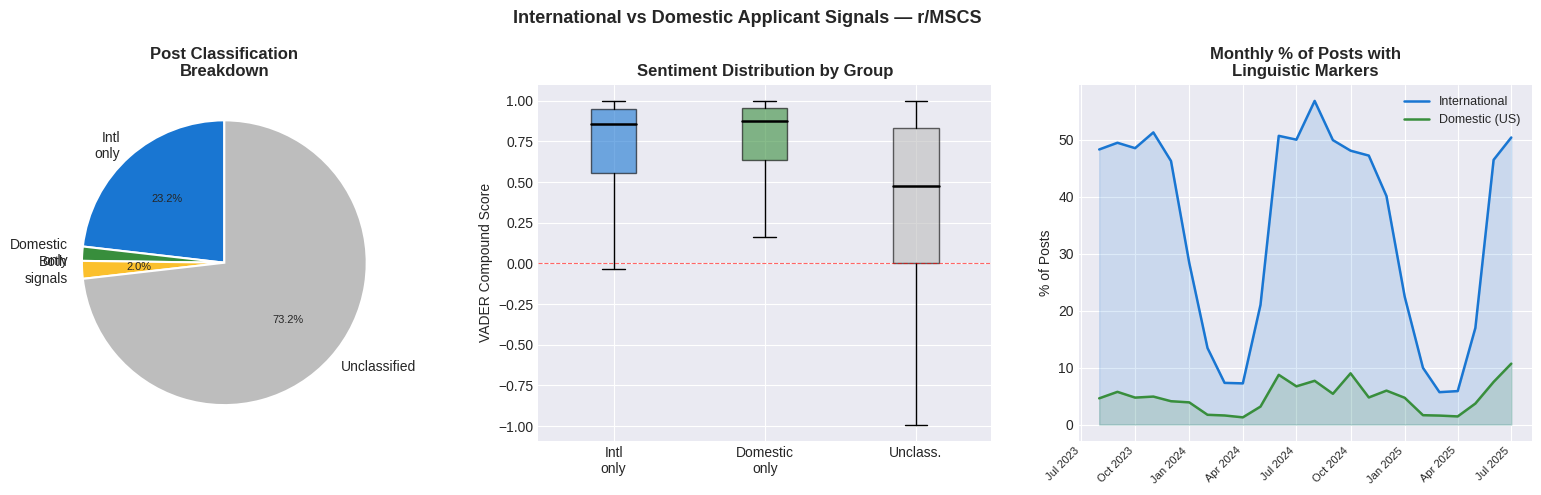

Saved: outputs/intl_markers_over_time.png


In [3]:
import numpy as np

# ── Marker patterns (identical to r/gradadmissions for cross-subreddit comparison) ──
intl_pattern = re.compile(
    r'\bcgpa\b'
    r'|\b\d[\d\.]+\s*/\s*10\b'          # "9.2/10" or "8.5 / 10"
    r'|\bb\.?tech\b|\bb\.e\.'             # B.Tech, B.E.
    r'|\blakhs?\b|\blacs?\b|\bcrores?\b|\binr\b'
    r'|\bielts\b|\btoefl\b'                      # ELP tests (intl-only)
    r'|\btier\s*[1-3]\b',
    re.IGNORECASE,
)

domestic_pattern = re.compile(
    r'\b[0-3]\.\d+\s*(?:gpa\b|/\s*4)'    # "3.8 gpa" or "3.8/4"
    r'|\bgpa\s*of\s*[0-3]\.\d'             # "gpa of 3.8"
    r'|\bout\s*of\s*4\b'
    r'|\bfafsa\b'
    r'|\bin-?state\b|\bout-?of-?state\b'
    r'|\bstate\s+school\b'
    r'|\bsat\s*score\b|\bact\s*score\b',
    re.IGNORECASE,
)

posts['is_intl']     = posts['full_text'].apply(
    lambda t: bool(intl_pattern.search(t)) if isinstance(t, str) else False)
posts['is_domestic'] = posts['full_text'].apply(
    lambda t: bool(domestic_pattern.search(t)) if isinstance(t, str) else False)

intl_only = posts['is_intl'] & ~posts['is_domestic']
dom_only  = posts['is_domestic'] & ~posts['is_intl']
both_mask = posts['is_intl'] & posts['is_domestic']
neither   = ~posts['is_intl'] & ~posts['is_domestic']
total     = len(posts)

print(f"Total posts       : {total:,}")
print(f"  Intl only       : {intl_only.sum():,}  ({intl_only.mean()*100:.1f}%)")
print(f"  Domestic only   : {dom_only.sum():,}  ({dom_only.mean()*100:.1f}%)")
print(f"  Both signals    : {both_mask.sum():,}  ({both_mask.mean()*100:.1f}%)")
print(f"  Unclassified    : {neither.sum():,}  ({neither.mean()*100:.1f}%)")

# ── Sentiment by group ────────────────────────────────────────────────────────
s_intl = posts[intl_only]['sentiment_score'].mean()
s_dom  = posts[dom_only]['sentiment_score'].mean()
s_oth  = posts[neither]['sentiment_score'].mean()
print(f"\nMean VADER sentiment:")
print(f"  Intl-only    : {s_intl:.3f}")
print(f"  Domestic-only: {s_dom:.3f}")
print(f"  Unclassified : {s_oth:.3f}")

# ── Admit / reject mention rates by group ────────────────────────────────────
admit_re  = re.compile(r'\badmit(ted)?\b|\baccepted\b|\boffer\b', re.IGNORECASE)
reject_re = re.compile(r'\breject(ed)?\b|\bdinged?\b|\bdenied\b', re.IGNORECASE)
posts['mentions_admit']  = posts['full_text'].apply(
    lambda t: bool(admit_re.search(t))  if isinstance(t, str) else False)
posts['mentions_reject'] = posts['full_text'].apply(
    lambda t: bool(reject_re.search(t)) if isinstance(t, str) else False)

print("\nAdmit / Reject mention rates:")
for label, mask in [('Intl-only', intl_only), ('Domestic-only', dom_only), ('Unclassified', neither)]:
    sub = posts[mask]
    a = sub['mentions_admit'].mean() * 100
    r = sub['mentions_reject'].mean() * 100
    ratio = f"{a/r:.2f}" if r > 0 else "n/a"
    print(f"  {label:16s}  admit {a:.1f}%  reject {r:.1f}%  ratio {ratio}:1")

# ── 3-panel chart ─────────────────────────────────────────────────────────────
COLORS = {'intl': '#1976D2', 'dom': '#388E3C', 'both': '#FBC02D', 'unk': '#BDBDBD'}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1 — Donut: classification breakdown
sizes  = [intl_only.sum(), dom_only.sum(), both_mask.sum(), neither.sum()]
labels = ['Intl\nonly', 'Domestic\nonly', 'Both\nsignals', 'Unclassified']
colors = [COLORS['intl'], COLORS['dom'], COLORS['both'], COLORS['unk']]
wedges, texts, autotexts = axes[0].pie(
    sizes, labels=labels, colors=colors,
    autopct=lambda p: f'{p:.1f}%' if p > 2 else '',
    startangle=90, wedgeprops=dict(edgecolor='white', linewidth=1.5),
)
for t in autotexts: t.set_fontsize(8)
axes[0].set_title('Post Classification\nBreakdown', fontweight='bold')

# Panel 2 — Box plot: sentiment by group
groups = {
    'Intl\nonly':     posts[intl_only]['sentiment_score'],
    'Domestic\nonly': posts[dom_only]['sentiment_score'],
    'Unclass.':        posts[neither]['sentiment_score'],
}
bp = axes[1].boxplot(
    [g.dropna().values for g in groups.values()],
    labels=list(groups.keys()),
    patch_artist=True,
    medianprops=dict(color='black', lw=1.8),
    showfliers=False,
)
for patch, col in zip(bp['boxes'], [COLORS['intl'], COLORS['dom'], COLORS['unk']]):
    patch.set_facecolor(col); patch.set_alpha(0.6)
axes[1].axhline(0, color='red', ls='--', lw=0.8, alpha=0.6)
axes[1].set_title('Sentiment Distribution by Group', fontweight='bold')
axes[1].set_ylabel('VADER Compound Score')

# Panel 3 — Line: monthly % with each signal
posts['_marker_month'] = posts['created_dt'].dt.to_period('M')
monthly_intl_pct = posts.groupby('_marker_month')['is_intl'].mean() * 100
monthly_dom_pct  = posts.groupby('_marker_month')['is_domestic'].mean() * 100
x_ts = monthly_intl_pct.index.to_timestamp()

axes[2].plot(x_ts, monthly_intl_pct.values, color=COLORS['intl'], lw=1.8, label='International')
axes[2].plot(x_ts, monthly_dom_pct.values,  color=COLORS['dom'],  lw=1.8, label='Domestic (US)')
axes[2].fill_between(x_ts, monthly_intl_pct.values, alpha=0.15, color=COLORS['intl'])
axes[2].fill_between(x_ts, monthly_dom_pct.values,  alpha=0.15, color=COLORS['dom'])
axes[2].set_title('Monthly % of Posts with\nLinguistic Markers', fontweight='bold')
axes[2].set_ylabel('% of Posts')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
axes[2].legend(fontsize=9)

posts.drop(columns=['_marker_month'], inplace=True)

plt.suptitle('International vs Domestic Applicant Signals — r/MSCS',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/intl_markers_over_time.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: outputs/intl_markers_over_time.png")


## 3. Bias and Demographic Skew Analysis
To address potential biases (like self-selection or platform demographic skew), we can look at two factors:
1. **Posting Hours**: Plotting the hour of the day posts are created. We convert post timestamps to **US Central Time** (CST/CDT) and overlay IST reference bands. A spike in the midnight–7 am CT window (= IST 11:30 am–7:30 pm) would confirm that a large fraction of posters are based in India.
2. **Admit vs Reject Bias (Self-Selection)**: People are generally more likely to post their 'Acceptances' than 'Rejections'. We can do a quick keyword tally to see if the subreddit portrays an unrealistically high acceptance rate.

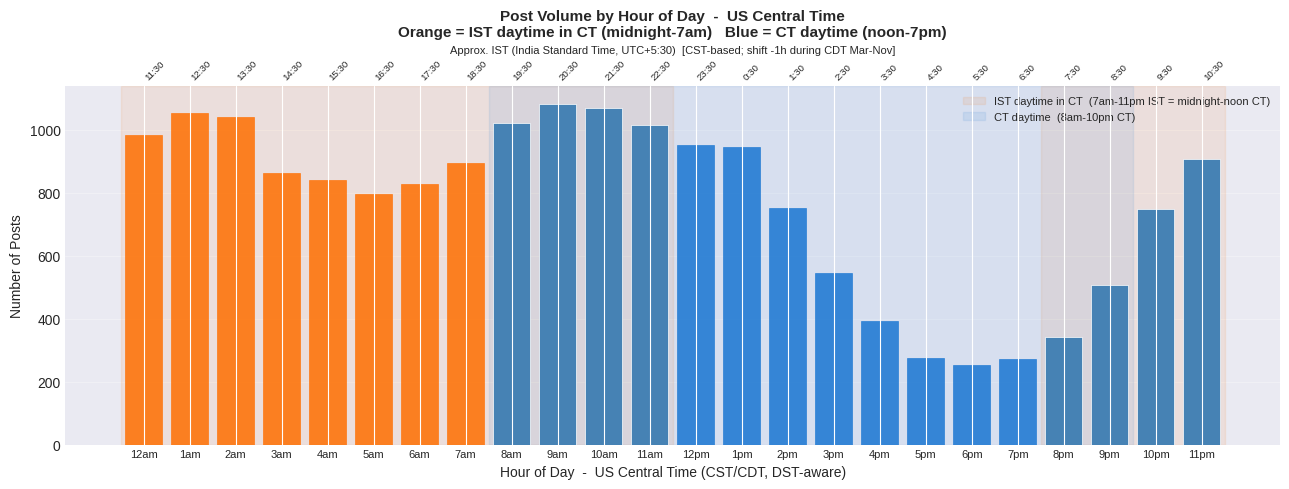

Saved: outputs/posting_hours_skew.png
Posts mentioning Admits: 6257
Posts mentioning Rejects: 1569
Ratio (Admit:Reject) = 3.99:1
Conclusion: Strong self-selection bias. Users are highly biased toward posting positive outcomes.


In [4]:
from zoneinfo import ZoneInfo

# ── Convert UTC → US Central Time (DST-aware: CST UTC-6 / CDT UTC-5) ─────────
CT = ZoneInfo('America/Chicago')
posts['hour_ct'] = posts['created_dt'].dt.tz_convert(CT).dt.hour
hour_counts_ct   = posts['hour_ct'].value_counts().sort_index().reindex(range(24), fill_value=0)

# ── Reference bands ──────────────────────────────────────────────────────────
# IST (UTC+5:30) active day  ~7am-11pm IST
#   CT (CST) equiv = IST - 11h30m  ->  CT 19:30-11:30 (wraps midnight)
#   Shade CT 0-11 (midnight-noon) and 20-23 (8pm-midnight)
# CT daytime  8am-10pm CT  ->  CT hours 8-21
IST_BAND_COLOR = '#FF6F00'
CT_BAND_COLOR  = '#1976D2'

fig, ax = plt.subplots(figsize=(13, 5))

# Background shading (drawn first so bars appear on top)
ax.axvspan(-0.5, 11.5, alpha=0.09, color=IST_BAND_COLOR, zorder=1,
           label='IST daytime in CT  (7am-11pm IST = midnight-noon CT)')
ax.axvspan(19.5, 23.5, alpha=0.09, color=IST_BAND_COLOR, zorder=1)
ax.axvspan(7.5,  21.5, alpha=0.09, color=CT_BAND_COLOR,  zorder=1,
           label='CT daytime  (8am-10pm CT)')

bars = ax.bar(hour_counts_ct.index, hour_counts_ct.values,
              color='steelblue', edgecolor='white', linewidth=0.5, zorder=3)

# Colour bars by which timezone zone they fall in
IST_ONLY_HOURS = set(range(0, 8))    # midnight-7am CT  (IST: 11:30am-7:30pm)
CT_ONLY_HOURS  = set(range(12, 20)) # noon-7pm CT      (IST: 11:30pm-6:30am)
for bar, h in zip(bars, hour_counts_ct.index):
    if h in IST_ONLY_HOURS:
        bar.set_color('#FF6F00'); bar.set_alpha(0.85)
    elif h in CT_ONLY_HOURS:
        bar.set_color('#1976D2'); bar.set_alpha(0.85)

# ── Primary (CT) x-axis ──────────────────────────────────────────────────────
ax.set_xticks(range(24))
ct_labels = []
for h in range(24):
    if h == 0:    lbl = '12am'
    elif h < 12:  lbl = f'{h}am'
    elif h == 12: lbl = '12pm'
    else:         lbl = f'{h-12}pm'
    ct_labels.append(lbl)
ax.set_xticklabels(ct_labels, fontsize=8)
ax.set_xlabel('Hour of Day  -  US Central Time (CST/CDT, DST-aware)', fontsize=10)
ax.set_ylabel('Number of Posts')
ax.grid(axis='y', alpha=0.3, zorder=0)

# ── Secondary (IST) x-axis at top ────────────────────────────────────────────
# IST = CT + 11h30m (CST) / CT + 10h30m (CDT). Labels use CST-based offset.
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(range(24))
ist_labels = []
for h in range(24):
    total_min = h * 60 + 11 * 60 + 30   # CST -> IST
    ih, im    = (total_min // 60) % 24, total_min % 60
    ist_labels.append(f'{ih}:{im:02d}')
ax2.set_xticklabels(ist_labels, fontsize=7, rotation=45, ha='left')
ax2.set_xlabel(
    'Approx. IST (India Standard Time, UTC+5:30)'
    '  [CST-based; shift -1h during CDT Mar-Nov]',
    fontsize=8)

ax.set_title(
    'Post Volume by Hour of Day  -  US Central Time\n'
    'Orange = IST daytime in CT (midnight-7am)   Blue = CT daytime (noon-7pm)',
    fontsize=11, fontweight='bold')
ax.legend(fontsize=8, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.savefig('outputs/posting_hours_skew.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/posting_hours_skew.png')

# ── 2. Admit vs Reject Self-Selection Bias ───────────────────────────────────
admit_pattern  = re.compile(r'\badmit|\baccepted|\boffer|\bgot in\b', re.IGNORECASE)
reject_pattern = re.compile(r'\breject|\bdenied|\bdinged',              re.IGNORECASE)

posts['mentions_admit']  = posts['full_text'].apply(lambda x: bool(admit_pattern.search(x)))
posts['mentions_reject'] = posts['full_text'].apply(lambda x: bool(reject_pattern.search(x)))

admit_count  = posts['mentions_admit'].sum()
reject_count = posts['mentions_reject'].sum()

print(f'Posts mentioning Admits: {admit_count}')
print(f'Posts mentioning Rejects: {reject_count}')
print(f'Ratio (Admit:Reject) = {admit_count/max(1, reject_count):.2f}:1')
print('Conclusion: Strong self-selection bias. Users are highly biased toward posting positive outcomes.')


## 4. Bot and Noise Impact (Challenges Faced)
How much of the raw data was actually noise? This visualization will show exactly how much data was purged due to deletion/removal or bot-authorship, which is a great talking point for the 'Challenges' section.

Raw posts       : 18,799
Deleted/removed : 390
Bot authors     : 37
Kept (clean)    : 18,372


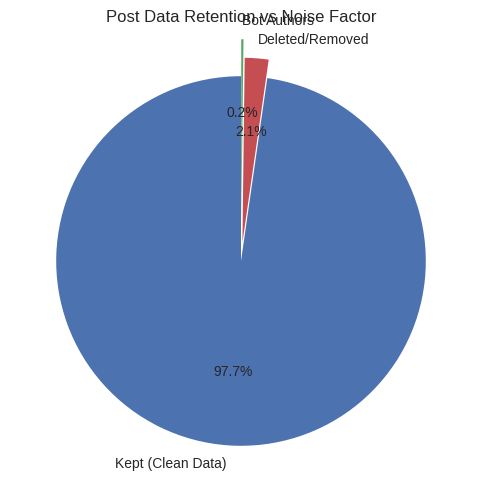

In [5]:
# Load per-stage counts from the stats file saved by clean_mscs_data.ipynb.
# This replaces the old hardcoded numbers and removes the need to re-run
# bot detection logic inside this notebook.
with open('data/r_MSCS_cleaning_stats.json') as f:
    _ps = json.load(f)['posts']

n_raw     = _ps['n_raw']
n_deleted = _ps['n_deleted']
n_bots    = _ps['n_bots']
n_kept    = _ps['n_clean']

print(f"Raw posts       : {n_raw:,}")
print(f"Deleted/removed : {n_deleted:,}")
print(f"Bot authors     : {n_bots:,}")
print(f"Kept (clean)    : {n_kept:,}")

labels  = ['Kept (Clean Data)', 'Deleted/Removed', 'Bot Authors']
sizes   = [n_kept, n_deleted, n_bots]
explode = (0, 0.1, 0.2)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#4C72B0', '#C44E52', '#55A868'])
plt.title('Post Data Retention vs Noise Factor')
plt.savefig('outputs/noise_impact_pie.png', dpi=150)
plt.show()

## 5. Metadata and Engagement Distribution
Reddit data is unique because of community voting and comment threads. Let's look at the distribution of engagement (Comments and Scores). The 'long tail' is very characteristic of social media data.

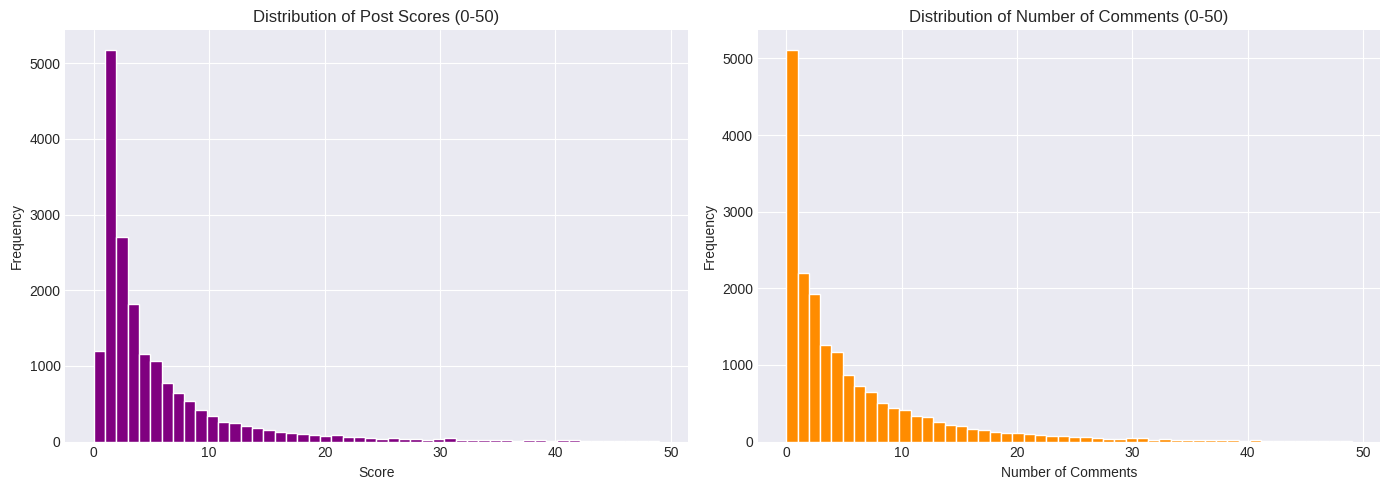

Median Score: 3.0
Median Comments: 2.0


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Post Scores (Zoomed in to 0-50 to avoid massive outliers ruining the view)
axes[0].hist(posts[posts['score'] < 50]['score'], bins=50, color='purple', edgecolor='white')
axes[0].set_title('Distribution of Post Scores (0-50)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Plot Number of Comments (Zoomed in 0-50)
axes[1].hist(posts[posts['num_comments'] < 50]['num_comments'], bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Distribution of Number of Comments (0-50)')
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('outputs/engagement_long_tail.png', dpi=150)
plt.show()

print(f"Median Score: {posts['score'].median()}")
print(f"Median Comments: {posts['num_comments'].median()}")


## 6. Real-World Events & Temporal Correlation

The subreddit's activity is tightly coupled to two external clocks: the **CS admissions calendar** and the **tech industry/policy environment**. This section overlays known events on the time series to make that coupling visible.

### 6a. Annotated Post Volume & Sentiment

Three event categories are colour-coded:

| Category | Colour | Examples |
|---|---|---|
| **Cycle** (admissions milestones) | Blue | App deadlines (Dec), decisions (Feb–Mar), enrol deadline (Apr 15) |
| **Industry** (tech market) | Red | Jan 2024 tech layoff wave |
| **Policy** (immigration) | Orange | H-1B lottery (Apr), 2024 US election (Nov), new admin policies (Jan 2025) |

Expected patterns to look for:
- Post **volume spikes** around Dec (deadlines) and Feb–Apr (decisions)
- **Sentiment dips** around decision season — anxiety over rejections
- **Sentiment drop** around election / new admin policy announcements — international-student concern

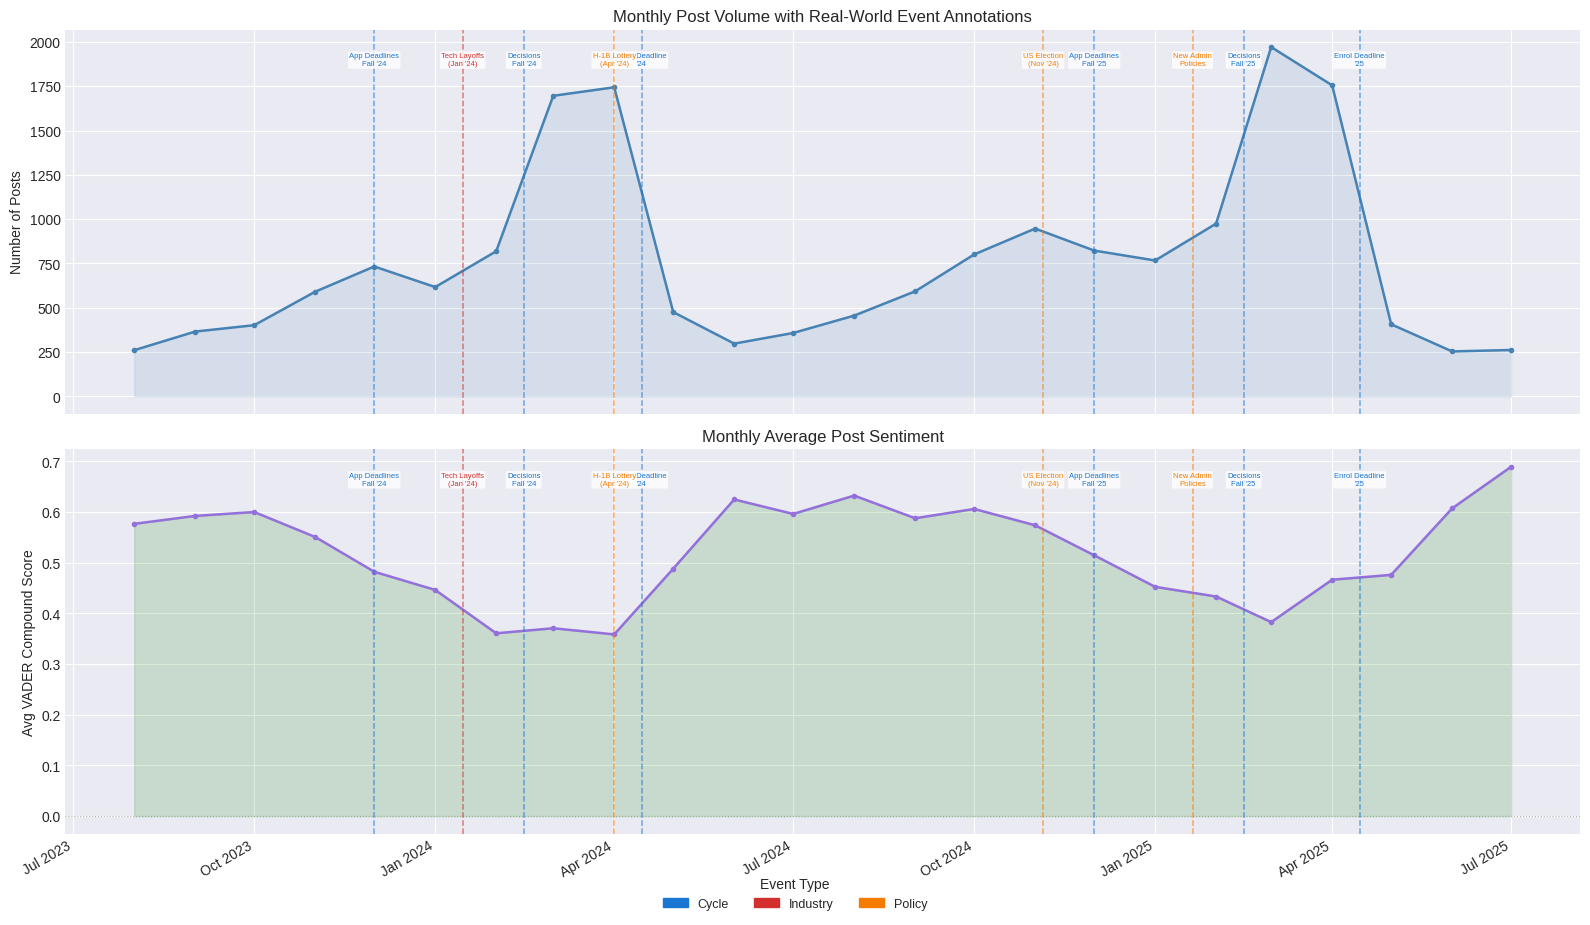

In [7]:
# ── 6a. Annotated Post Volume & Sentiment ────────────────────────────────────
# Real-world events annotated as vertical dashed lines.
# Three categories (colour-coded):
#   cycle    — admissions calendar milestones (deadlines, decisions, enrolment)
#   industry — tech layoff waves
#   policy   — immigration / political events (H-1B lottery, US election, new admin)

EVENTS = [
    # ── Admissions cycle — Fall 2024 applications ──
    ('2023-12-01', "App Deadlines\nFall '24",  'cycle'),
    ('2024-02-15', "Decisions\nFall '24",       'cycle'),
    ('2024-04-15', "Enrol Deadline\n'24",        'cycle'),
    # ── Admissions cycle — Fall 2025 applications ──
    ('2024-12-01', "App Deadlines\nFall '25",  'cycle'),
    ('2025-02-15', "Decisions\nFall '25",       'cycle'),
    ('2025-04-15', "Enrol Deadline\n'25",        'cycle'),
    # ── Tech industry ──
    ('2024-01-15', "Tech Layoffs\n(Jan '24)",   'industry'),
    # ── Policy / immigration ──
    ('2024-04-01', "H-1B Lottery\n(Apr '24)",   'policy'),
    ('2024-11-05', "US Election\n(Nov '24)",     'policy'),
    ('2025-01-20', "New Admin\nPolicies",        'policy'),
]

EVENT_COLORS = {'cycle': '#1976D2', 'industry': '#D32F2F', 'policy': '#F57C00'}


def annotate_events(ax, events, y_frac=0.94):
    """Draw labelled vertical lines for each event on *ax*."""
    ylim = ax.get_ylim()
    yspan = ylim[1] - ylim[0]
    for date_str, label, cat in events:
        ts = pd.Timestamp(date_str)
        ax.axvline(ts, color=EVENT_COLORS[cat], lw=1.1, ls='--', alpha=0.6)
        ax.text(
            ts, ylim[0] + yspan * y_frac, label,
            color=EVENT_COLORS[cat], fontsize=5.5, ha='center', va='top',
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.8),
        )


# Convert Period index → Timestamp for matplotlib date formatting
vol_ts  = posts.groupby('month').size().copy()
vol_ts.index = vol_ts.index.to_timestamp()

sent_ts = monthly_sentiment.copy()
sent_ts.index = sent_ts.index.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

# ── Top panel: post volume ────────────────────────────────────────────────────
axes[0].plot(vol_ts.index, vol_ts.values,
             color='steelblue', marker='o', ms=3, lw=1.8)
axes[0].fill_between(vol_ts.index, vol_ts.values, alpha=0.12, color='steelblue')
axes[0].set_ylabel('Number of Posts')
axes[0].set_title('Monthly Post Volume with Real-World Event Annotations')
annotate_events(axes[0], EVENTS)

# ── Bottom panel: sentiment ───────────────────────────────────────────────────
axes[1].plot(sent_ts.index, sent_ts.values,
             color='mediumpurple', marker='o', ms=3, lw=1.8)
axes[1].axhline(0, color='gray', ls=':', lw=0.8, alpha=0.6)
axes[1].fill_between(sent_ts.index, sent_ts.values,
                     where=sent_ts.values >= 0, alpha=0.15, color='green')
axes[1].fill_between(sent_ts.index, sent_ts.values,
                     where=sent_ts.values < 0,  alpha=0.15, color='red')
axes[1].set_ylabel('Avg VADER Compound Score')
axes[1].set_title('Monthly Average Post Sentiment')
annotate_events(axes[1], EVENTS)

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=30, ha='right')

# Shared event-type legend
legend_patches = [mpatches.Patch(color=v, label=k.title()) for k, v in EVENT_COLORS.items()]
fig.legend(handles=legend_patches, title='Event Type',
           loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.03), fontsize=9)

plt.tight_layout()
plt.savefig('outputs/events_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

### 6b. Keyword Group Prevalence Over Time

Five semantic keyword groups are tracked monthly to surface **what** is driving the correlation:

| Group | Example terms |
|---|---|
| Applications | SOP, LOR, deadline, apply |
| Decisions | accepted, rejected, waitlist, ding, interview |
| Visa & Work Auth | H-1B, OPT, STEM OPT, visa, sponsorship |
| Job Market | layoff, laid off, hiring freeze |
| Anxiety | worried, anxious, stressed, panicking |

When these are overlaid with the event lines, you can see that topic surges are *caused by* real events, not random noise — e.g. "Decisions" spikes sharply in Feb–Mar, "Applications" peaks Nov–Dec, and "Visa & Work Auth" rises after the H-1B lottery and the November 2024 election.

/tmp/ipykernel_264948/1426127670.py:38: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['_kw_month'] = posts['created_dt'].dt.to_period('M')


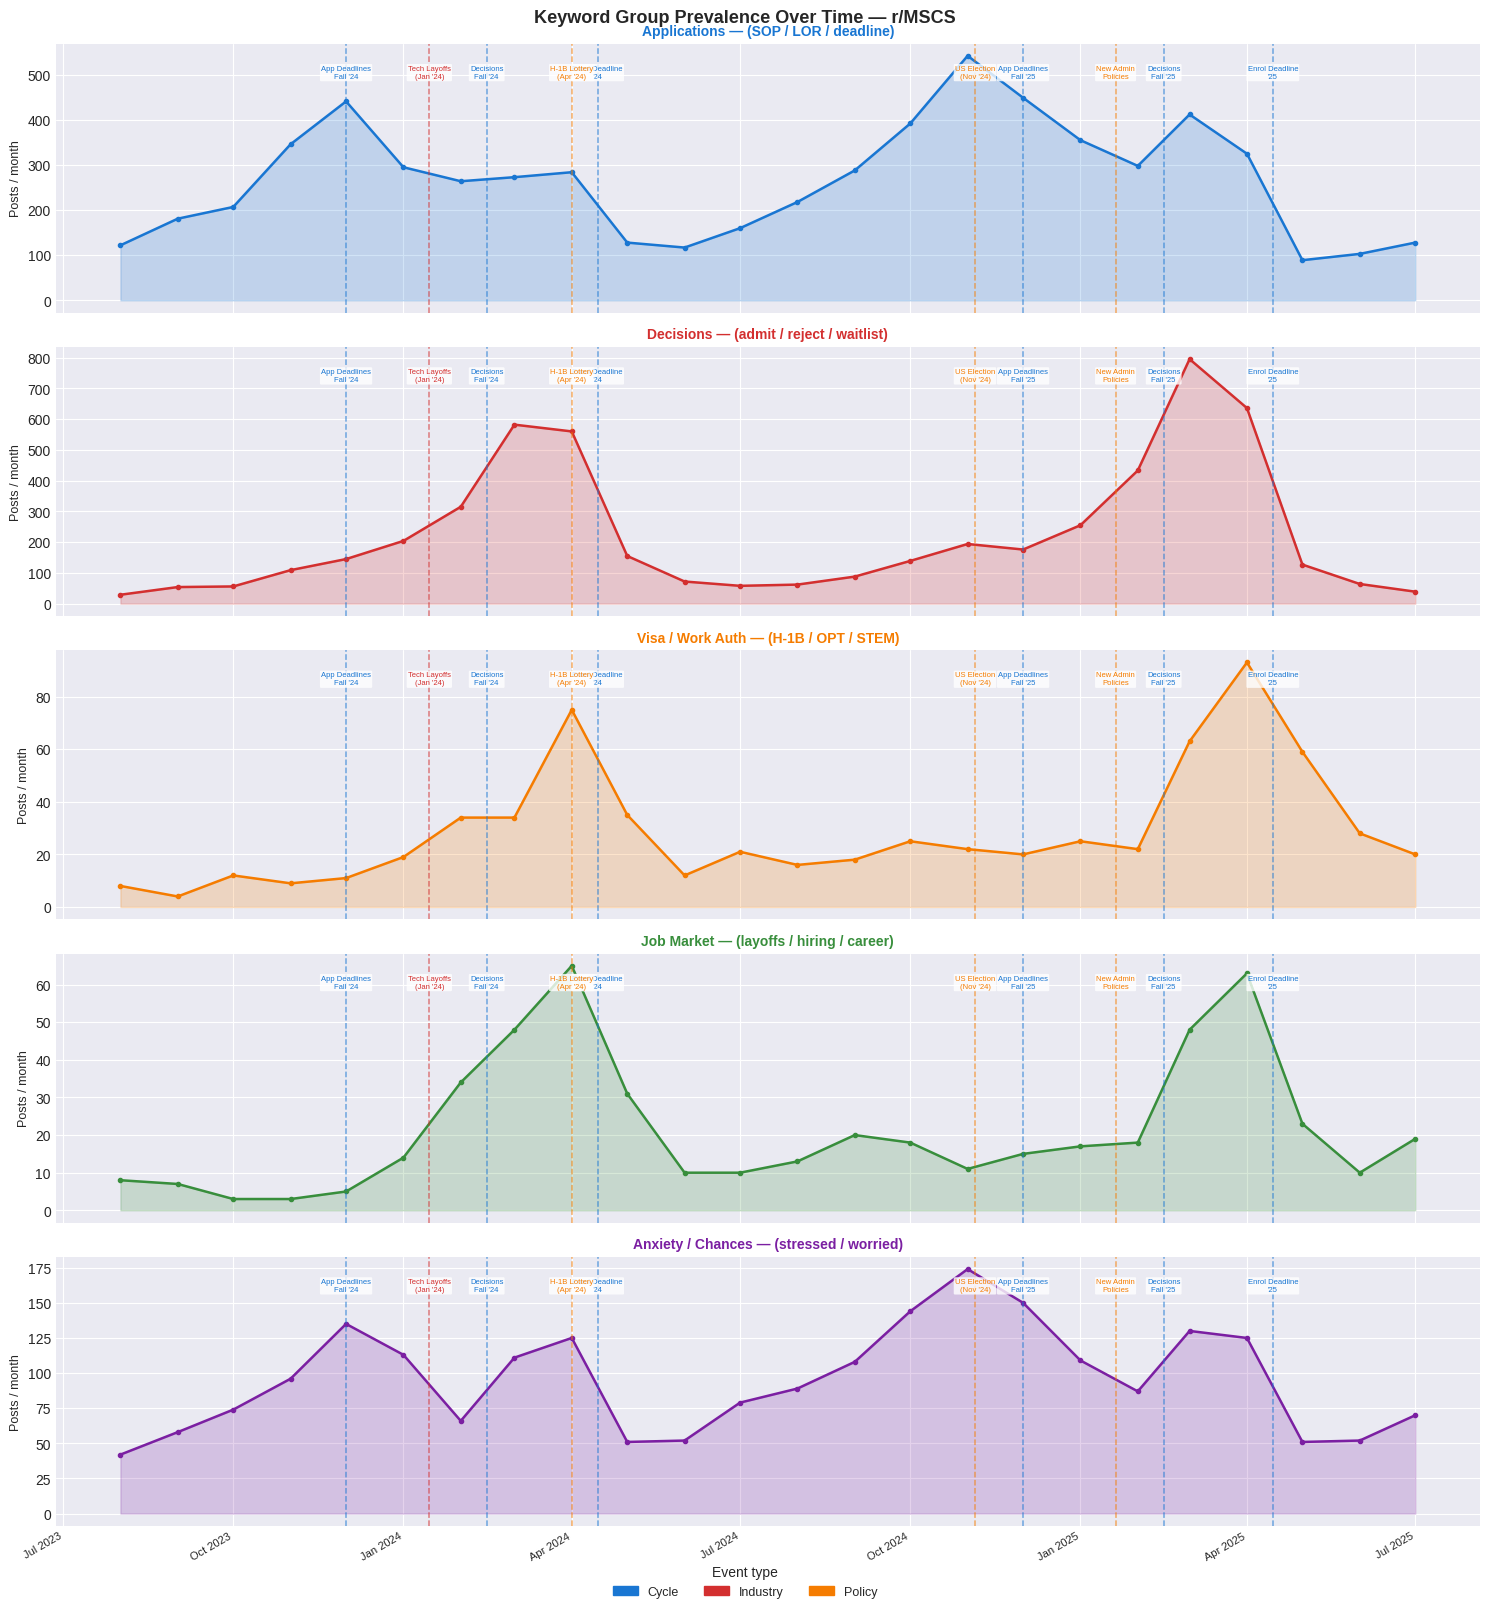

Saved: outputs/keyword_trends.png


In [8]:
# ── 6b. Keyword Group Prevalence Over Time ───────────────────────────────────
# Five semantic groups track *what* the subreddit is discussing each month.
# Same subplot-per-group format as r/gradadmissions for direct comparison.
# MSCS-specific groups: Job Market replaces Funding (CS career focus).

KEYWORD_GROUPS = {
    'Applications\n(SOP / LOR / deadline)': re.compile(
        r'\bSOP\b|\bstatement of purpose\b|\bLOR\b|\bdeadline\b'
        r'|\bappl(y|ied|ication)\b',
        re.IGNORECASE,
    ),
    'Decisions\n(admit / reject / waitlist)': re.compile(
        r'\baccepted\b|\brejected\b|\bwaitlist\b|\bding(ed)?\b'
        r'|\badmit(ted)?\b|\bdecision\b|\binterview\b',
        re.IGNORECASE,
    ),
    'Visa / Work Auth\n(H-1B / OPT / STEM)': re.compile(
        r'\bH.?1.?B\b|\bOPT\b|\bSTEM\s*OPT\b|\bvisa\b'
        r'|\bwork\s*auth\b|\bsponsorship\b|\bimmigration\b',
        re.IGNORECASE,
    ),
    'Job Market\n(layoffs / hiring / career)': re.compile(
        r'\blayoff\b|\blaid\s*off\b|\bjob\s*market\b'
        r'|\bhiring\s*freeze\b|\bjob\s*offer\b|\btech\s*job\b',
        re.IGNORECASE,
    ),
    'Anxiety / Chances\n(stressed / worried)': re.compile(
        r'\bworried\b|\banxious\b|\bstress(ed)?\b|\bnervous\b'
        r'|\bhopeless\b|\bscared\b|\bpanic\b'
        r'|\bchances?\b|\bchance me\b',
        re.IGNORECASE,
    ),
}

GROUP_COLORS = ['#1976D2', '#D32F2F', '#F57C00', '#388E3C', '#7B1FA2']

posts['_kw_text']  = posts['title'].fillna('') + ' ' + posts['selftext'].fillna('')
posts['_kw_month'] = posts['created_dt'].dt.to_period('M')

fig, axes = plt.subplots(len(KEYWORD_GROUPS), 1,
                         figsize=(15, 3.2 * len(KEYWORD_GROUPS)), sharex=True)

for ax, (group_name, pattern), color in zip(axes, KEYWORD_GROUPS.items(), GROUP_COLORS):
    col = f'_kw_{group_name}'
    posts[col] = posts['_kw_text'].apply(lambda t: bool(pattern.search(t)))
    monthly_kw = posts.groupby('_kw_month')[col].sum()

    x_ts = monthly_kw.index.to_timestamp()
    ax.fill_between(x_ts, monthly_kw.values, alpha=0.20, color=color)
    ax.plot(x_ts, monthly_kw.values, color=color, lw=1.8, marker='o', ms=3)

    ax.set_ylabel('Posts / month', fontsize=9)
    ax.set_title(group_name.replace('\n', ' — '), fontsize=10, fontweight='bold', color=color)

    annotate_events(ax, EVENTS, y_frac=0.92)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right', fontsize=8)

legend_patches = [mpatches.Patch(color=v, label=k.title()) for k, v in EVENT_COLORS.items()]
fig.legend(handles=legend_patches, title='Event type',
           loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02), fontsize=9)

plt.suptitle('Keyword Group Prevalence Over Time — r/MSCS',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/keyword_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: outputs/keyword_trends.png')

posts.drop(columns=[c for c in posts.columns if c.startswith('_kw_')], inplace=True)
